# COM4509/6509 MLAI - Assignment Part 2 Brief


## A. Reproducibility & readability

In [1]:
import numpy as np
np.random.seed(16166)       
import torch
torch.manual_seed(16166)

## B. Logistic Regression on BreastMNIST [9 marks]


### B1 Data loading and inspection [3 mark]

Firstly we should import the data and commonly used API

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

torch.manual_seed(16166)

B_data_flag = 'breastmnist'
B_download = True

B_NUM_EPOCHS = 3
B_BATCH_SIZE = 128
B_lr = 0.001

B_info = INFO[B_data_flag]
B_task = B_info['task']
B_n_channels = B_info['n_channels']
B_n_classes = len(B_info['label'])
B_DataClass = getattr(medmnist, B_info['python_class'])

First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [3]:
# preprocessing
B_data_transform = transforms.Compose([
    transforms.ToTensor(), # Covert PIL to np.ndarray(H*W*C)
    transforms.Normalize(mean=[.5], std=[.5]) # Normalized
])

# load the data
train_dataset = B_DataClass(split='train', transform=B_data_transform, download=B_download)
val_dataset =  B_DataClass(split='val',    transform=B_data_transform, download=B_download)
test_dataset = B_DataClass(split='test',   transform=B_data_transform, download=B_download)
# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form, which is irrtable 
train_loader = data.DataLoader(dataset=train_dataset, batch_size=B_BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=B_BATCH_SIZE, shuffle= False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*B_BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Zhou Qinzhi\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\Zhou Qinzhi\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\Zhou Qinzhi\.medmnist\breastmnist.npz


In [4]:
print("Trainingset size:",len(train_dataset))
print("Validation size", len(val_dataset))
print("Test set size:",len(test_dataset))

Trainingset size: 546
Validation size 78
Test set size: 156


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #rearrange dimensions to numpy format for disply
    plt.show()

# get some random training images
train_dataiter = iter(train_loader)
val_dataiter = iter(val_loader)
test_dataiter = iter(test_loader)

train_images, train_labels = train_dataiter.next() #     # next used to get the value(tensor)
val_images, val_labels = val_dataiter.next()    
test_images, test_labels = test_dataiter.next() 


In [6]:
def findindex(labels): # Make a function to return 2 lists
    a = []
    b = []
    for i in range(len(labels)):
        if labels[i] == 0: # list the index number of == 0 labes which will be used select the images,
            a.append(i) # 
        elif labels[i] == 1: # same as above as the value == 1
            b.append(i) #
    return a, b
        
train_list_0_index, train_list_1_index = findindex(train_labels)
train_indice_0, train_indice_1  =  torch.tensor(train_list_0_index[0:10]),  torch.tensor(train_list_1_index[0:10])
train_images_0, train_images_1 = torch.index_select(train_images, 0, train_indice_0),torch.index_select(train_images, 0, train_indice_1)


val_list_0_index, val_list_1_index = findindex(val_labels)
val_indice_0, val_indice_1  =  torch.tensor(val_list_0_index[0:10]),  torch.tensor(val_list_1_index[0:10])
val_images_0, val_images_1 = torch.index_select(val_images, 0, val_indice_0),torch.index_select(val_images, 0, val_indice_1)

test_list_0_index, test_list_1_index = findindex(test_labels)
test_indice_0, test_indice_1  =  torch.tensor(test_list_0_index[0:10]),  torch.tensor(test_list_1_index[0:10])
test_images_0, test_images_1 = torch.index_select(test_images, 0, test_indice_0),torch.index_select(test_images, 0, test_indice_1)

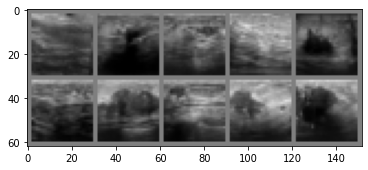

 10 images of '0: malignant'from training set  


In [7]:
# show images
imshow(torchvision.utils.make_grid(train_images_0, nrow= 5))
print( " 10 images of '0: malignant'from training set  ")

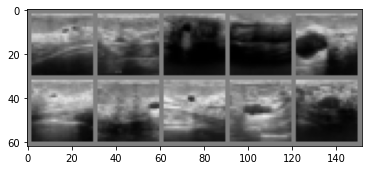

 10 images of '1: normal, benign' from training set 


In [8]:
imshow(torchvision.utils.make_grid(train_images_1, nrow= 5))
print( " 10 images of '1: normal, benign' from training set ")

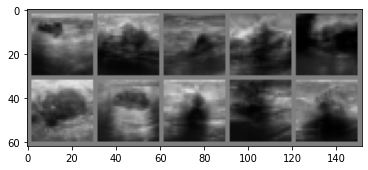

 10 images of '0: malignant'from validation set  


In [9]:
imshow(torchvision.utils.make_grid(val_images_0, nrow= 5))
print( " 10 images of '0: malignant'from validation set  ")

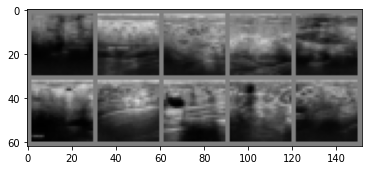

 10 images of '1: normal, benign'from validation set  


In [10]:
imshow(torchvision.utils.make_grid(val_images_1, nrow= 5))
print( " 10 images of '1: normal, benign'from validation set  ")

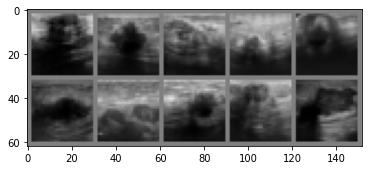

 10 images of '0: malignant'from test set  


In [11]:
imshow(torchvision.utils.make_grid(test_images_0, nrow= 5))
print( " 10 images of '0: malignant'from test set  ")

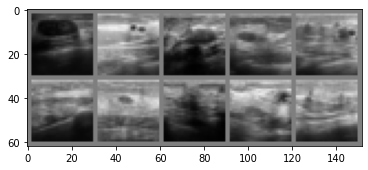

 10 images of'1: normal, benignfrom test set  


In [12]:
imshow(torchvision.utils.make_grid(test_images_1, nrow= 5))
print( " 10 images of'1: normal, benignfrom test set  ")

## B2 Logistic Regression
### Using logistic regression function in scikit_learn to build the model

In [13]:
# Processing the data
X_train, Y_train = train_images, train_labels
X_train_transformed = np.reshape(X_train, (X_train.shape[0], X_train.shape[2]*X_train.shape[3]))
X_val, Y_val_labels = val_images, val_labels
X_val_transformed = np.reshape(X_val,(X_val.shape[0], X_val.shape[2]*X_val.shape[3]))
X_test, Y_test_labels = test_images, test_labels
X_test_transformed = np.reshape(X_test,(X_test.shape[0], X_test.shape[2]*X_test.shape[3]))

In [14]:
from sklearn import linear_model# from sklearn import linear model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Set some parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear'] # Algorithm to use in the optimization problem. 
# For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
#For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
penalty = ['l2'] # The quesition force to use l2 
c_values = [100, 10, 1.0, 0.1, 0.01] # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
tol_values = [10,1, 0.1, 0.01, 0.001]

# We need find best c

# define models and parameters
logisticRegr = linear_model.LogisticRegression(random_state = 16166,  max_iter=200) # Build a model of LR with parameter
model =  logisticRegr.fit(X_train_transformed, np.ravel(Y_train)) # Firstly we used our train data to train our model

# define grid search, with opizimization the parameter with using Validatiob data set 
grid = dict(solver=solvers,penalty=penalty,C=c_values, tol = tol_values) # dict the parameters
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # K folds
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

# The grid search with the parameter with the model we trained before to find the best parameters like C and solvers.
grid_result = grid_search.fit(X_val_transformed, np.ravel(Y_val_labels)) # Use validation to test the model 

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.816071 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 1}


In [15]:
model_after_opt =  linear_model.LogisticRegression(C = 0.1, penalty = 'l2', solver = 'liblinear', tol =1,random_state = 16166,  max_iter=200)

In [16]:
model_after_opt.fit(X_train_transformed,  np.ravel(Y_train))

LogisticRegression(C=0.1, max_iter=200, random_state=16166, solver='liblinear',
                   tol=1)

In [17]:
from sklearn.metrics import accuracy_score
Y_train_predicted = model_after_opt.predict(X_train_transformed)
M1 = accuracy_score(Y_train, Y_train_predicted, normalize = True)
Y_val_predicted =  model_after_opt.predict(X_val_transformed)
M2 = accuracy_score(Y_val_labels, Y_val_predicted, normalize= True)
Y_test_predicted =  model_after_opt.predict(X_test_transformed)
M3 = accuracy_score(Y_test_labels, Y_test_predicted, normalize= True)
print("M1/M2/M3: ", M1, M2,M3, " Prediction accuracy get by sklearn")

M1/M2/M3:  0.828125 0.8205128205128205 0.7692307692307693  Prediction accuracy get by sklearn


### Using logistic regression function in Pytorch to build the model

In [18]:
import torch
import torch.nn.functional as F
torch.manual_seed(16166) # For reproducibility


In [19]:
# Firstly design the Pytorch model using nn.module
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim) # Linear transform

    def forward(self, x):
        x = self.linear(x)
        outputs = torch.sigmoid(x) # Activation
        return outputs # The data output

In [20]:
batch_size = B_BATCH_SIZE # 128
n_iters = 3000
epochs = n_iters / (len(train_dataset) / batch_size) # Epoch is a measure of the number of times all training data is used once to update the parameters.
input_dim = 784 # X have 28 * 28 inputs features
output_dim = 1 # Single binary output  
lr_rate = 0.00001

In [21]:
model = LogisticRegression(input_dim, output_dim)
criterion =  torch.nn.BCELoss() 

In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate, weight_decay=1e-3)

In [23]:
from torch.autograd import Variable
iter = 0
Acc = []
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        
        
        labels = labels.numpy()
        labels=(torch.from_numpy(labels.astype(np.float32)))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter % 500==0:
            # calculate Accuracy
            correct = 0
            for images, labels in train_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                
                prediction = outputs
                
            for i in range(len(prediction)):
                if prediction[i] > 0.5:
                    prediction[i] = 1
                else:
                    prediction[i] = 0
                    
            
            for i in range(len(prediction)):
                if prediction[i] == labels[i]:
                    correct += 1
    
            accuracy = correct/len(prediction)
            Acc.append(accuracy)
        
            
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(),accuracy))
MaxAcc = max(Acc)
M1_2=MaxAcc

Iteration: 500. Loss: 0.6441065669059753. Accuracy: 0.7058823529411765.
Iteration: 1000. Loss: 0.5975757837295532. Accuracy: 0.7352941176470589.
Iteration: 1500. Loss: 0.646494448184967. Accuracy: 0.7941176470588235.
Iteration: 2000. Loss: 0.6290810108184814. Accuracy: 0.5294117647058824.
Iteration: 2500. Loss: 0.5375903844833374. Accuracy: 0.7352941176470589.
Iteration: 3000. Loss: 0.5570725798606873. Accuracy: 0.8235294117647058.
Iteration: 3500. Loss: 0.6540635824203491. Accuracy: 0.6764705882352942.


In [24]:
epochs = n_iters / (len(val_dataset) / batch_size)
from torch.autograd import Variable
iter = 0
Acc = []
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(val_loader):
        
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        
        
        labels = labels.numpy()
        labels=(torch.from_numpy(labels.astype(np.float32)))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter % 500==0:
            # calculate Accuracy
            correct = 0
            for images, labels in train_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                
                prediction = outputs
                
            for i in range(len(prediction)):
                if prediction[i] > 0.5:
                    prediction[i] = 1
                else:
                    prediction[i] = 0
                    
            
            for i in range(len(prediction)):
                if prediction[i] == labels[i]:
                    correct += 1
    
            accuracy = correct/len(prediction)  
            Acc.append(accuracy)
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(),accuracy))
MaxAcc = max(Acc)
M2_2=MaxAcc

Iteration: 500. Loss: 0.5811497569084167. Accuracy: 0.7647058823529411.
Iteration: 1000. Loss: 0.576988697052002. Accuracy: 0.8235294117647058.
Iteration: 1500. Loss: 0.5734804272651672. Accuracy: 0.7352941176470589.
Iteration: 2000. Loss: 0.5704353451728821. Accuracy: 0.5588235294117647.
Iteration: 2500. Loss: 0.5677227973937988. Accuracy: 0.7058823529411765.
Iteration: 3000. Loss: 0.565251886844635. Accuracy: 0.8823529411764706.
Iteration: 3500. Loss: 0.5629591345787048. Accuracy: 0.7941176470588235.
Iteration: 4000. Loss: 0.5607999563217163. Accuracy: 0.5882352941176471.
Iteration: 4500. Loss: 0.5587425827980042. Accuracy: 0.8529411764705882.


In [25]:
from torch.autograd import Variable
iter = 0
Acc = []
epochs = n_iters / (len(test_dataset) / batch_size)
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(test_loader):
        
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        
        
        labels = labels.numpy()
        labels=(torch.from_numpy(labels.astype(np.float32)))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter % 500==0:
            # calculate Accuracy
            correct = 0
            for images, labels in train_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                
                prediction = outputs
                
            for i in range(len(prediction)):
                if prediction[i] > 0.5:
                    prediction[i] = 1
                else:
                    prediction[i] = 0
                    
            
            for i in range(len(prediction)):
                if prediction[i] == labels[i]:
                    correct += 1
    
            accuracy = correct/len(prediction)
            Acc.append(accuracy)
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(),accuracy))

MaxAcc = max(Acc)
M3_2=MaxAcc

Iteration: 500. Loss: 0.5786978006362915. Accuracy: 0.7352941176470589.
Iteration: 1000. Loss: 0.5774114727973938. Accuracy: 0.7058823529411765.
Iteration: 1500. Loss: 0.5761463642120361. Accuracy: 0.7352941176470589.
Iteration: 2000. Loss: 0.5749008059501648. Accuracy: 0.6470588235294118.


## B3 Performance Comparison
### a)

In [26]:
print("M1/M2/M3: ", M1, M2,M3, " Prediction accuracy get by sklearn")

M1/M2/M3:  0.828125 0.8205128205128205 0.7692307692307693  Prediction accuracy get by sklearn


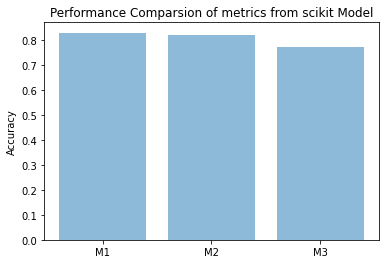

In [27]:
import matplotlib.pyplot as plt ## for ploting

objects = ('M1', 'M2', 'M3')
y_pos = np.arange(len(objects))

metrices1 = [M1, M2, M3]

plt.bar(y_pos, metrices1, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Performance Comparsion of metrics from scikit Model')
plt.show()

In [28]:
print("M1/M2/M3: ", M1_2, M2_2,M3_2, " Prediction accuracy get by sklearn")

M1/M2/M3:  0.8235294117647058 0.8823529411764706 0.7352941176470589  Prediction accuracy get by sklearn


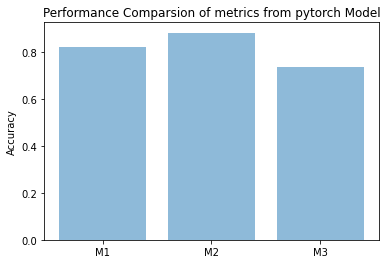

In [29]:
import matplotlib.pyplot as plt ## for ploting

objects = ('M1', 'M2', 'M3')
y_pos = np.arange(len(objects))

metrices2 = [M1_2, M2_2, M3_2]

plt.bar(y_pos, metrices2, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Performance Comparsion of metrics from pytorch Model')
plt.show()

#### b.

From question a, I found the best parameters is C=0.1 for l2 regularization in logistic regression in sklearn model. The accuracy for traing and validation set are higher than 80% and 77% on testset which is reasonalble. In pytorch model the validation set play better than test and train set.

## C. Convolutional Neural Networks on OCTMNIST

### C1. Data Loading and inspection

In [30]:
c_data_flag = 'octmnist'
c_download = True


c_NUM_EPOCHS = 381 # 94744/256
c_BATCH_SIZE = 256
c_lr = 0.001


c_info = INFO['octmnist']
c_task = c_info['task']
c_n_channels = c_info['n_channels']
c_n_classes = len(c_info['label'])

DataClass = getattr(medmnist, c_info['python_class'])

In [31]:
# preprocessing
c_data_transform = transforms.Compose([
    transforms.ToTensor(), # Covert PIL to np.ndarray(H*W*C)
    transforms.Normalize(mean=[.5], std=[.5]) # Normalized
])

# load the data
c_train_dataset = DataClass(split='train', transform=c_data_transform, download=c_download)
c_val_dataset =  DataClass(split='val',    transform=c_data_transform, download=c_download)
c_test_dataset = DataClass(split='test',   transform=c_data_transform, download=c_download)
# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form, which is irrtable 
c_train_loader = data.DataLoader(dataset=c_train_dataset, batch_size=c_BATCH_SIZE, shuffle=True)
c_val_loader = data.DataLoader(dataset=c_val_dataset, batch_size=c_BATCH_SIZE, shuffle= False)
c_test_loader = data.DataLoader(dataset=c_test_dataset, batch_size=2*c_BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Zhou Qinzhi\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Zhou Qinzhi\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\Zhou Qinzhi\.medmnist\octmnist.npz


In [32]:
print("Trainingset size:",len(c_train_dataset))
print("Validation size:",len(c_val_dataset))
print("Test size:",len(c_test_dataset)) # Use validation set as test set

Trainingset size: 97477
Validation size: 10832
Test size: 1000


In [33]:
def findindex_4classes(labels): # Make a function to return 2 lists
    a = []
    b = []
    c = []
    d = []
    for i in range(len(labels)):
        if labels[i] == 0: # list the index number of == 0 labes which will be used select the images,
            a.append(i) # 
        elif labels[i] == 1: # same as above as the value == 1
            b.append(i) #
        elif labels[i] == 2:
            c.append(i) 
        else:
            d.append(i)
    return a, b, c, d


In [34]:
# get some random training images
c_train_dataiter = c_train_loader.__iter__()
c_val_dataiter = c_val_loader.__iter__()
c_test_dataiter = c_test_loader.__iter__()

c_train_images, c_train_labels = c_train_dataiter.next() #     # next used to get the value(tensor)
c_val_images, c_val_labels = c_val_dataiter.next()    
c_test_images, c_test_labels = c_test_dataiter.next() 

In [35]:
c_train_0_index, c_train_1_index, c_train_2_index, c_train_3_index = findindex_4classes(c_train_labels)
c_train_indice_0, c_train_indice_1, c_train_indice_2, c_train_indice_3  =  torch.tensor(c_train_0_index[0:10]),  torch.tensor(c_train_1_index[0:10]), torch.tensor(c_train_2_index[0:10]),  torch.tensor(c_train_3_index[0:10])
c_train_images_0, c_train_images_1, c_train_images_2, c_train_images_3 = torch.index_select(c_train_images, 0, c_train_indice_0),torch.index_select(c_train_images, 0,c_train_indice_1),torch.index_select(c_train_images, 0,c_train_indice_2), torch.index_select(c_train_images, 0,c_train_indice_3)

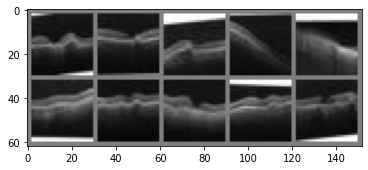

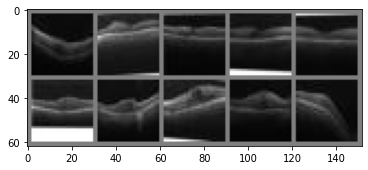

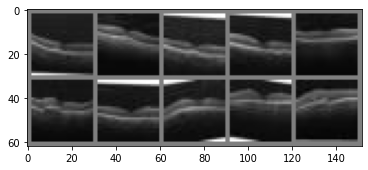

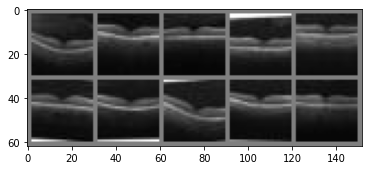

 10 images of labels '0,1,2,3 '


In [36]:
# show images
imshow(torchvision.utils.make_grid(c_train_images_0, nrow= 5)),imshow(torchvision.utils.make_grid(c_train_images_1, nrow= 5))
imshow(torchvision.utils.make_grid(c_train_images_2, nrow= 5)),imshow(torchvision.utils.make_grid(c_train_images_3, nrow= 5))
print( " 10 images of labels '0,1,2,3 '")

### C2. Convolutional neural networks
#### a. Design a CNN with two Conv layers and two FC layers.

In [37]:
class CNN_a(nn.Module):
    def __init__(self): # 2 Conv and 2 FC
        super(CNN_a, self).__init__() # 1* 28 * 28 images
        self.conv1 = nn.Conv2d(1, 6, 5) #1: #input channels black and wight color; 6: #output channels; 5: kernel size 6*24*24
        self.pool  = nn.MaxPool2d(2,2)# 6*12*12
        self.conv2 = nn.Conv2d(6, 16, 5)# 16*8* 8 16*4*4 SECOND POOL
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 120
        self.fc2 = nn.Linear(120, 4) # 84
       # number of classes is 4
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
      
        return x

CNN_a = CNN_a()

In [38]:
max_epochs = 5     #381
c_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_a.parameters(), lr=0.01, momentum=0.9)

tic = time.time() # time 
for epoch in range(max_epochs):  # loop over the dataset multiple times here i
    running_loss = 0.0
    for i, data in enumerate(c_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        #forward + backward + optimize
        
        outputs = CNN_a(inputs)
        labels = labels.long()
        labels = labels.squeeze(1)
        #outputs = outputs.float()
        
        loss = c_criterion(outputs, labels)
        loss.backward()
        optimizer.step()       
        
        running_loss += loss.item()
        if i % 200 == 199:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
print('Finished Training!')

training_time = time.time() - tic
M4a = training_time
print("Trainning Time(s): ", training_time)

[1,   200] loss: 1.166
[2,   200] loss: 0.756
[3,   200] loss: 0.633
[4,   200] loss: 0.563
[5,   200] loss: 0.516
Finished Training!
Trainning Time(s):  95.07191061973572


In [39]:
def getAccuracy(dataset,cnn):
    correct = 0
    total = 0
    CNN = cnn
    with torch.no_grad():  #testing phase, no need to compute the gradients to save time
        for data in dataset:
            images, labels = data
            labels = labels.squeeze(1)
            outputs = CNN_a(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accur = 100 * correct / total
    print('Accuracy of the network on this set: ', accur )
    return (100 * correct / total)

In [40]:
M1a = getAccuracy(c_train_loader,  CNN_a)

Accuracy of the network on this set:  83.06369707725925


In [41]:
M2a = getAccuracy(c_val_loader, CNN_a)

Accuracy of the network on this set:  83.2533234859675


In [42]:
M3a = getAccuracy(c_test_loader,  CNN_a)

Accuracy of the network on this set:  63.5


#### b. Design a CNN with three Conv layers and three FC layers

In [43]:
class CNN_b(nn.Module):
    def __init__(self): # 2 Conv and 2 FC
        super(CNN_b, self).__init__() # 1* 28 * 28 images
        self.conv1 = nn.Conv2d(1, 6, 5, padding = "same") #1: #input channels black and wight color; 6: #output channels; 5: kernel size 6*28*28
        self.pool  = nn.MaxPool2d(2,2)# 6*14*14
        self.conv2 = nn.Conv2d(6, 12, 5, padding = "same")# 12*14*14 SECOND POOL
        self.conv3 = nn.Conv2d(12, 16, 5,padding = "same")# 16*3*3
        
        self.fc1 = nn.Linear(16 * 3* 3, 120)  # 120
        self.fc2 = nn.Linear(120, 84) # 84
        self.fc3 = nn.Linear(84, 4) # number of classes
        
         
            
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 16 * 3 *3)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

CNN_b = CNN_b()

In [44]:
max_epochs = 5       #381
c_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_a.parameters(), lr=0.01, momentum=0.9)
tic = time.time() # time 

for epoch in range(max_epochs):  # loop over the dataset multiple times
    running_loss_b = 0
    for i, data in enumerate(c_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputss, labelss = data
        # zero the parameter gradients
        optimizer.zero_grad()
        #forward + backward + optimize
        
        outputs = CNN_b(inputss)
        labelss = labelss.long()
        labelss = labelss.squeeze(1)
        #outputs = outputs.float()
        
        loss_b = c_criterion(outputs, labelss)
        loss_b.backward()
        optimizer.step()        
       
        running_loss_b += loss_b.item()
        if i % 200 == 199:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss_b / 200))
        running_loss_b = 0.0
training_time  =  time.time() - tic
M4b = training_time
print("Trainning Time(s): ", training_time)

[1,   200] loss: 0.007
[2,   200] loss: 0.007
[3,   200] loss: 0.007
[4,   200] loss: 0.007
[5,   200] loss: 0.007
Trainning Time(s):  111.0070788860321


In [45]:
M1b = getAccuracy(c_train_loader,  CNN_b)

Accuracy of the network on this set:  83.06369707725925


In [46]:
M2b = getAccuracy(c_val_loader,  CNN_b)

Accuracy of the network on this set:  83.2533234859675


In [47]:
M3b =getAccuracy(c_test_loader,  CNN_b)

Accuracy of the network on this set:  63.5


#### C3. Performance comparison

#### c.

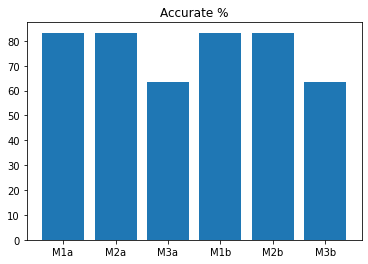

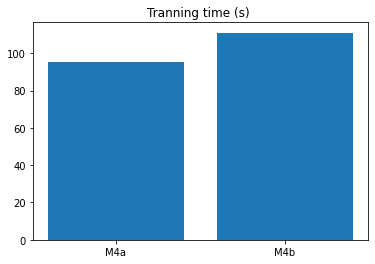

In [48]:
acc_list = [M1a,M2a,M3a,M1b,M1b,M2b,M3b]
plt.bar(['M1a','M2a','M3a','M1b','M1b','M2b','M3b'],acc_list)
plt.title('Accurate %')
plt.show()

time_list = [M4a, M4b]
plt.bar(['M4a','M4b'],time_list)
plt.title('Tranning time (s) ')
plt.show()

#### d.

Accroding to the bar chart, it clear show two CNN models have similar performance and both of them play better on the trainset. For both of them the performance are very similar the train and validation set with 0.02% difference. This may caused by source training set is split with a ratio of 9 : 1 into training and validation sets. It also be oberved that the second model need longer training time because the deeper layer.

## D. Unsupervised learning on Fashine-MNIST

### D1 Dimensionality reduction

In [49]:
from torchvision import datasets, transforms

In [50]:
batchSize=256
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])
#Load the training data
d_trainset = datasets.FashionMNIST(root='./data', train=True,download=True, transform=transform)
d_trainloader = torch.utils.data.DataLoader(d_trainset, batch_size=batchSize, shuffle=True, num_workers=2)
#Load the test data
d_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
d_testloader = torch.utils.data.DataLoader(d_testset, batch_size=batchSize, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser','Pullover','Dress', 'Coat' ,'Sandal','Shirt','Sneaker','Bag','Ankle boot')
chosen_classes = ('Coat' ,'Sandal')

print('Training set size:', len(d_trainset))
print('Test set size:',len(d_testset))

Training set size: 60000
Test set size: 10000


#### a.

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [52]:
idx = (d_testset.targets == 1)|(d_testset.targets == 5)
twoclasses_targets = d_testset.targets[idx]
twoclasses_data = d_testset.data[idx]
twoclasses_data_X = twoclasses_data[:].numpy().reshape(2000, 28*28)
scaler.fit(twoclasses_data_X)
twoclasses_data_X = scaler.transform(twoclasses_data_X)

In [53]:
X = twoclasses_data_X
pca = PCA(n_components=30)
pca.fit(X)
X_pca = pca.transform(X)
cov_matrix = np.dot(X.T, X) / len(X)
X_pca.shape


(2000, 30)

In [54]:
pc_df = pd.DataFrame(data = X_pca )
pc30= pc_df.iloc[:, 0:31] 
pc30 = np.array(pc30)

In [55]:
top_5 = []
# The descending eigenvalues
for eigenvector in pca.components_[:5]:
    eigenvalues = np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))
    print(eigenvalues)
    top_5.append(eigenvector)

194.16773150431425
71.62592757339722
51.02045801610993
32.63409038586623
24.346811695042184


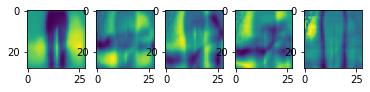

In [56]:
# The visualization of eigenvectors
import matplotlib.pyplot as plt
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(top_5[i].reshape(28,28))

#### b.

In [57]:
Trouser = []
dress = []
for i in  range(len(twoclasses_targets)):
    if twoclasses_targets[i] == 1:
        Trouser.append(i)
    else:
        dress.append(i)
            

In [58]:
pca.components_.shape
pca_rep = np.dot(X_pca, pca.components_)
y = pca_rep.reshape(2000, 28,28)

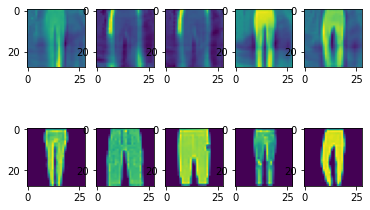

In [59]:
import random
randomlist_1 = random.sample(Trouser, 5)
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(y[randomlist_1[i]])
for i in range(6,11):
    plt.subplot(2,5,i)
    plt.imshow(twoclasses_data[randomlist_1[i-6]].reshape(28,28))    

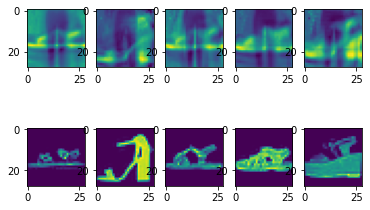

In [60]:
randomlist_3 = random.sample(dress, 5)
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(y[randomlist_3[i]])
for i in range(6,11):
    plt.subplot(2,5,i)
    plt.imshow(twoclasses_data[randomlist_3[i-6]].reshape(28,28))   

#### c.

In [61]:
pc_df = pd.DataFrame(data = X_pca )
targets = pd.DataFrame(data =twoclasses_targets )
targets.columns = ['cluster']

In [62]:
pc12= pc_df.iloc[:, 0:2] 
pc12.columns = ['PC1','PC2'] 
pc12 = pd.concat([pc12, targets], axis=1)
pc12

,PC1,PC2,cluster
0,-18.948026,0.759168,1
1,-11.446805,-3.393871,1
2,-14.921729,4.404485,1
3,9.114846,-10.363924,5
4,13.901400,-4.230153,5
...,...,...,...
1995,16.098505,28.213311,5
1996,-13.856865,-2.592743,1
1997,-4.376574,-6.037555,1
1998,-12.116862,-3.658289,1


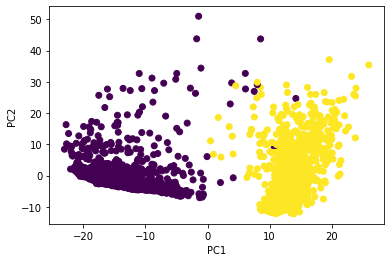

In [63]:
plt.scatter(pc12.iloc[:,0], pc12.iloc[:,1], c=pc12.iloc[:,2])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show() 

#### d.

In [64]:
d_X_train = np.array(pc12.iloc[:, 0:2])
d_X_train.reshape(2000,2)

array([[-18.94802572,   0.75916839],
       [-11.44680527,  -3.39387101],
       [-14.92172911,   4.40448517],
       ...,
       [ -4.37657415,  -6.03755454],
       [-12.11686209,  -3.65828898],
       [ 11.45787809,  -3.65542614]])

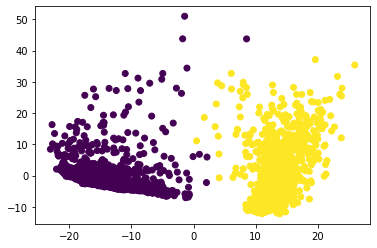

<Figure size 432x288 with 0 Axes>

In [65]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

x = d_X_train
sc = SpectralClustering(n_clusters=2, n_jobs = 2, gamma = 0.1).fit(x)

labels = sc.labels_
plt.scatter(x[:,0], x[:,1], c=labels)
plt.show()
f = plt.figure()
plt.show() 
  

#### e.

In [66]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 4, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 8, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
AE=Autoencoder()

In [67]:
#Training (optimisation) parameters
batch_size=64
learning_rate=1e-3
max_epochs = 22

#Choose mean square error loss
criterion = nn.MSELoss() 
#Choose the Adam optimiser
optimizer = torch.optim.Adam(AE.parameters(), lr=learning_rate, weight_decay=1e-5)
#Specify how the data will be loaded in batches (with random shuffling)
#Storage
outputs = []

#Start training
for epoch in range(max_epochs):
    for data in d_trainloader:
        img, label = data
        optimizer.zero_grad()
        recon = AE(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()            
    if (epoch % 2) == 0:
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon),)
    


Epoch:1, Loss:0.6866
Epoch:3, Loss:0.6315
Epoch:5, Loss:0.6320
Epoch:7, Loss:0.6180
Epoch:9, Loss:0.6018
Epoch:11, Loss:0.5834
Epoch:13, Loss:0.6090
Epoch:15, Loss:0.5855
Epoch:17, Loss:0.6231
Epoch:19, Loss:0.6054
Epoch:21, Loss:0.5778


### D2. Observation

Anwswer: I have use different classes of target to do experiemnt with the I model I made. I obervsed that the accuracy of cluster play differently with their classes. eg. The cluster preformed well when cluster shoes VS T-shirt/top, nut badly with T-shirt/top VS Coat. I might be caused the oringinally the similarity of the images data. For example, the top clothes are similar even human is not able to classfy them clearly. The images of them have similar features such as similar edges and shape. It might bring great influence with the model. However those images which dont have same features like shoes and cloths, the model plays very good performance. From Question A to B we can see that the PCA is sucessful to reduce the dimensionality and also be able to reseve the information, the reconstruction is sucessful and the image is coressponing to the origin images. From Question c to d on the first 2 PC, the data point can be easily clustered 2 classes which means the first 2 PCs is enough for building a cluster in a low (2d) dimensional space. The model also preformed well as the figure show only has few errors.Question e show that the autoencoder error is being well minimised.